# Object recognition and computer vision 2022-2023

## Assignment 3: Image classification

### Adapted from: Rob Fergus and Soumith Chintala

### Student: Théo Di Piazza (MVA)

In [2]:
# Import libraries
import argparse
import os
import glob
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import warnings
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
from torchvision import datasets
from torchvision.models import resnet18, resnet50, resnet152
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from skimage.io import imsave
from math import ceil, floor
from PIL import ImageOps
from tqdm import tqdm

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Folder of the project
folder = '/content/drive/MyDrive/ENS_MVA/Object_Recognition/TP3' #os.path.join(folder, data)
data_path = os.path.join(folder, 'bird_dataset_github') # Path of the bird dataset
data_path = os.path.join(folder, 'bird_dataset_cropped_github') # Path of the bird dataset

# Hide warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Mounted at /content/drive


In [12]:
# Training settings
batch_size = 16 # default 64
epochs = 50 
lr = 0.1 # default learning rate
momentum = 0.5 # SGD momentum
seed = 1 # random seed
log_interval = 10 # how many batches to wait before logging training status
experiment = "experiment" # folder where experiment outputs are located.
use_cuda = torch.cuda.is_available() # use cuda if available

## Chapters:

- Load data

- Pre-processing

- Display data

- Models

- Training

- Evaluation

## Load data

In [13]:
input_size = 224 # default 64

# transforms to load data
data_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # For Data Augmentation
    transforms.RandomRotation([10, 20], interpolation=Image.BILINEAR), # Rotation
    #transforms.GaussianBlur(5, 1), # Gaussian Blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# transforms to load initial data without data augmentation
data_transforms_print = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor()
])

In [14]:
# Load data with DataLoader
print(f'Data will be loaded from {data_path}\n')

# train set
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(os.path.join(data_path, 'train_images'),
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1) # Load it
if(train_loader):
  print('Train set loaded successfully!')

# validation set
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(os.path.join(data_path, 'val_images'),
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1) # Load it
if(val_loader):
  print('Validation set loaded successfully!')

# original dataset to print
original_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(os.path.join(data_path, 'val_images'),
                         transform=data_transforms_print),
    batch_size=batch_size, shuffle=True, num_workers=1) # Load it
if(original_loader):
  print('Original to be printed loaded successfully!')

Data will be loaded from /content/drive/MyDrive/ENS_MVA/Object_Recognition/TP3/bird_dataset_cropped_github

Train set loaded successfully!
Validation set loaded successfully!
Original to be printed loaded successfully!


# Pre-Processing : Segmentation the bird

The code bellow uses a R-CNN to segment/crop the bird from the initial image, in order to help the model to recognize it. If the bird is not found in the image, the initial image is conserved.

This code was run in the 'Pre-Processing Step' of the project, so before training models.

In [ ]:
# Pre-trained model to crop the bird
# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html
maskrcnn = maskrcnn_resnet50_fpn(pretrained = True).cuda() # Load it
maskrcnn.eval()

# To Tensor
transformTens = transforms.Compose([transforms.ToTensor()])

# Indice of bird for COCO list (Initialized before function)
indice_bird = 16 # 16 is the index of 'BIRD' in the list of all available object

# Function which crops the bird
def crop_bird(img):
  '''
  From a given image, crops the bird if a bird is present.
  Input:
    img(JpegImageFile): Image of the original dataset.
  Returns:
    (img, 1 if image is croped 0 otherwise)
  '''

  bird_found = 0 # Flag to indicate if a bird was found or not
  img_cropped = img

  # img to cuda
  img = transformTens(img).cuda()

  results_maskrcnn = maskrcnn([img]) # Get results from Mask RCNN
  labels_found = results_maskrcnn[0]['labels'].tolist() # Get labels found

  # If BIRD class was found by the model
  if(indice_bird in labels_found):
    
    bird_found = 1 # BIRD class was found

    scores_found = results_maskrcnn[0]['scores'].tolist() # Get scores of these labels
    box_found = results_maskrcnn[0]['boxes'].tolist()[labels_found.index(indice_bird)] # Get box to crop the bird

    # Extract the bird from its box
    x_left = ceil(box_found[0]) # Coordinates of the box
    x_right = floor(box_found[2])
    y_bot = ceil(box_found[1])
    y_top = floor(box_found[3])

    # Get the new image with only the bird
    img_cropped = img.cpu().permute(1, 2, 0).numpy()
    img_cropped = img_cropped[y_bot:y_top, x_left:x_right, :] 

  else:
    img_cropped = img.cpu().permute(1, 2, 0).numpy()

  return img_cropped, bird_found

Once the function is implemented, the following code permits to loop over all images to extract the bird. Then, images are saved in annother folder.

In [ ]:
# Path of the directory of cropped images
data_cropped_path = os.path.join(folder, 'bird_dataset_cropped')

# Check if directory of cropped images already exist, if not create it
if(not os.path.isdir(data_cropped_path)):

  # Directory with cropped images
  os.mkdir(data_cropped_path)

  # Create train/val/test folders which contain images
  os.mkdir(os.path.join(data_cropped_path, 'train_images'))
  os.mkdir(os.path.join(data_cropped_path, 'val_images'))
  os.mkdir(os.path.join(data_cropped_path, 'test_images'))
  os.mkdir(os.path.join(data_cropped_path, 'test_images/mistery_category'))

# Path of the directory with cropped images
data_cropped_path = os.path.join(folder, 'bird_dataset_cropped')

# Get all images from the initial dataset (train/val/test)
images = glob.glob(data_path + '/*/*/*') 

# For each image
for img_index in tqdm( range(len(images)) ):

  # Get the image and its path
  img, img_path = Image.open(images[img_index]), images[img_index]

  # Crop the image
  img_cropped, flag = crop_bird(img)
  #img = transform(img).cuda()

  # Get the path to save the cropped image
  img_cropped_path = img_path.replace('bird_dataset', 'bird_dataset_cropped')

  # If the path of the class does not exist, create it
  os.makedirs(os.path.dirname(img_cropped_path), exist_ok=True)

  # Save the image
  imsave(img_cropped_path, (img_cropped*255).astype(np.uint8))

## Display data

The code below will display 4 original pictures of the birds.

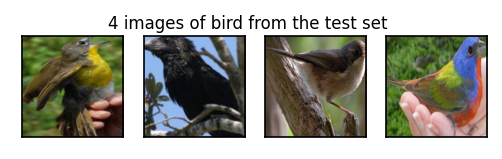

In [10]:
# Function to show an image
def imshow(imgs, nb_shown=4):
  '''
      Function to display ncol.nrow images with their labels
    args:
      imgs: (np.array) images
      nb_shown: (int) number of birds to display. Please select between 1 and 10.
    return:
      None
  '''

  # Initialize subplot
  plt.figure(figsize=(nb_shown, 1), dpi=150) # dpi controls resolution of figure

  # For each image to display
  i = 0 # Index of current image
  for img in imgs:

    i += 1

    # Adjuste image format to display it
    img = img.permute(1, 2, 0)

    # Display the image
    plt.subplot(1, nb_shown, i)
    plt.imshow(img)

    # Title and axes
    plt.xticks(())
    plt.yticks(())

  plt.suptitle(f"{nb_shown} images of bird from the test set", fontsize=8)

# Get training images  to display
dataiter = iter(original_loader)
images, labels = next(dataiter)

# Number of images to show
nb_shown = 4 # Please select between 1 and 10
images = images[:nb_shown]

# show images
imshow(images, nb_shown)

# Model

## Model 1 : Default from github

In [ ]:
# Class of the model
nclasses = 20

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, nclasses)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 320)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Model 2 : ResNet + Linear Layers

In [15]:
nclasses = 20

class ResNetLL(nn.Module):
  """
  Model which uses ResNet followed by linear layers
  """
  
  def __init__(self, version='50'):
    '''
    Initializes the model
    Input:
      version(str): version of the Resnet (50, 152...)
    '''
    super(ResNetLL, self).__init__()
    if(version=='18'):
      resnet = resnet18(pretrained=True)
    if(version=='50'):
      resnet = resnet50(pretrained=True)
    elif(version=='152'):
      resnet = resnet152(pretrained=True)
    if(resnet):
      print(f'ResNet{version} was loaded successfully!')
  
    # Extract layers of interest
    wanted_layers = list(resnet.children())[:-1]

    # ResNet Layer
    self.resnet = nn.Sequential(*wanted_layers)
    
    # Linear Layers - Change dimensions if wanted
    self.linear1 = nn.Linear(resnet.fc.in_features, 1000)
    self.linear2 = nn.Linear(1000, nclasses)

    # Dropout - Change probabilities
    self.dropout1 = nn.Dropout(p=0.6)
    self.dropout2 = nn.Dropout(p=0.4)
    
  def forward(self, x):
    '''
    Forward propagation of the Net for a given x.
    '''
    # First step : Resnet
    output = self.resnet(x)
    output = output.view(output.size(0), -1)

    # Linear Layer + Dropout + ReLU
    output = self.dropout1(output)
    output = F.relu(self.linear1(output))
    
    # Linear Layer + Dropout + ReLU
    output = self.dropout2(output)
    output = F.relu(self.linear2(output))

    return output

### Train and Test functions

In [19]:
def train(epoch):
    '''
    Train the model for a given epoch
    '''
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            
            
    return loss
            

def validation():
    '''
    Test the model on the validation dataset
    '''
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    # Compute accuracy
    accuracy = correct/len(val_loader.dataset)

    return accuracy

## Train/Validation of the model

In [ ]:
# If needed, please execute at first execution to speed-up
for batch_idx, (data, target) in enumerate(train_loader):
  print(batch_idx)

for batch_idx, (data, target) in enumerate(val_loader):
  print(batch_idx)

In [ ]:
# Initialize model
model = ResNetLL(version='152')

if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')

# Optimizer
optimizer = optim.Adam([{'params': list(model.children())[0].parameters(), 'lr': 1e-5},], lr=1e-4)

# Scheduler
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

# Train the model
print(f'Model trained with batch_size: {batch_size}')
losses = []
accuracies = []
epochs_list = []

for epoch in range(1, epochs + 1):

    # Train and validate
    train_loss = train(epoch)
    accuracy_validation = validation()
    
    # Save loss and accuracy
    losses.append(train_loss)
    accuracies.append(accuracy_validation)
    epochs_list.append(epoch)

    # Scheduler Step
    scheduler.step()

    # Save the model
    model_file = os.path.join(folder, experiment) + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

## Evaluate the model on the test set

In [21]:
# Parameters to evaluate the model
model_path = os.path.join(folder, experiment) + '/model_42.pth' # Please change if needed
outfile = os.path.join(folder, experiment) + '/kaggle.csv'

# Load the model and evaluate it on the test set
state_dict = torch.load(model_path)
model = ResNetLL(version='152')
model.load_state_dict(state_dict)
model.eval()
if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')

# path of the test dataset
test_dir = data_path + '/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

ResNet152 was loaded successfully!
Using GPU


100%|██████████| 517/517 [00:23<00:00, 22.14it/s]

Succesfully wrote /content/drive/MyDrive/ENS_MVA/Object_Recognition/TP3/experiment/kaggle.csv, you can upload this file to the kaggle competition website


# End, thank you for reading!

Théo Di Piazza

---